**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

**Load Data**

In [ ]:
df = pd.read_csv('pharma_data.csv')
print("Shape of data:", df.shape)
print(df.head())
print(df.info())

Shape of data: (3424, 69)
  Ptid Persistency_Flag  Gender           Race     Ethnicity   Region  \
0   P1       Persistent    Male      Caucasian  Not Hispanic     West   
1   P2   Non-Persistent    Male          Asian  Not Hispanic     West   
2   P3   Non-Persistent  Female  Other/Unknown      Hispanic  Midwest   
3   P4   Non-Persistent  Female      Caucasian  Not Hispanic  Midwest   
4   P5   Non-Persistent  Female      Caucasian  Not Hispanic  Midwest   

  Age_Bucket        Ntm_Speciality Ntm_Specialist_Flag  \
0        >75  GENERAL PRACTITIONER              Others   
1      55-65  GENERAL PRACTITIONER              Others   
2      65-75  GENERAL PRACTITIONER              Others   
3        >75  GENERAL PRACTITIONER              Others   
4        >75  GENERAL PRACTITIONER              Others   

       Ntm_Speciality_Bucket  ... Risk_Family_History_Of_Osteoporosis  \
0  OB/GYN/Others/PCP/Unknown  ...                                   N   
1  OB/GYN/Others/PCP/Unknown  ...       

**Define Target**

In [20]:
target = 'Persistency_Flag'
X = df.drop(columns=[target, 'Ptid'])
y = df[target]

# If target is string labels, encode:
if y.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    y = LabelEncoder().fit_transform(y)

**Detect Categorical + Numeric Collumns**

In [21]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

# Print to verify
print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure', 'Comorb_Disorders_of_lipoprot

**Handling Missing Values**

In [22]:
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

**Encoding Pipelines**

In [23]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore', dtype=int))
])

**Full Preprocessor**

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_imputer, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

**Full Model Pipeline**

In [26]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Grid Search**

In [27]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

print("\n=== Debugging Columns ===")
print("X_train columns:", X_train.columns.tolist())

missing_cols = [col for col in categorical_cols + numeric_cols if col not in X_train.columns]
print("Missing columns:", missing_cols)

# Fit GridSearchCV
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)



=== Debugging Columns ===
X_train columns: ['Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Density

**Evaluate Best Model**

In [28]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n=== FINAL MODEL PERFORMANCE ===")
print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("ROC AUC  :", round(roc_auc, 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== FINAL MODEL PERFORMANCE ===
Accuracy : 0.8161
Precision: 0.8056
Recall   : 0.6744
ROC AUC  : 0.8779

Confusion Matrix:
 [[385  42]
 [ 84 174]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       427
           1       0.81      0.67      0.73       258

    accuracy                           0.82       685
   macro avg       0.81      0.79      0.80       685
weighted avg       0.82      0.82      0.81       685



**Plot Roc Curve**

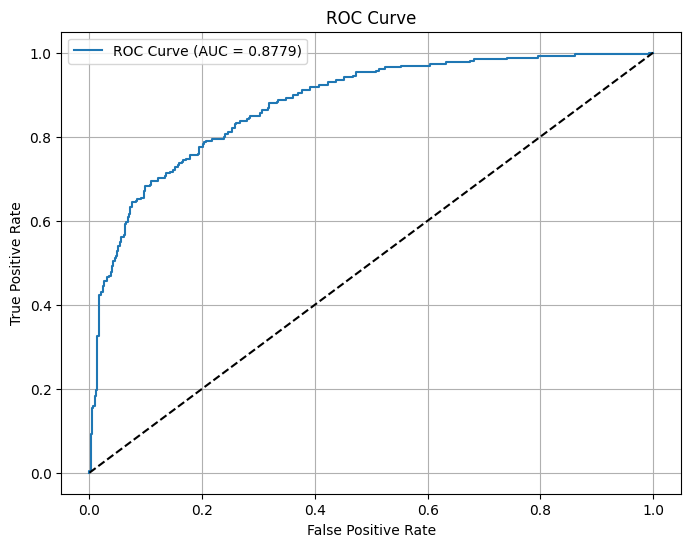

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

**Save Model**

In [30]:
joblib.dump(best_model, 'persistency_model.joblib')
print("Model saved to persistency_model.joblib")

Model saved to persistency_model.joblib
